<a href="https://colab.research.google.com/github/RoAlro/IA-codes-projects/blob/main/PROYECTO_CLASIFICADOR_DE_BASURA_RECICLABLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROYECTO CLASIFICADOR DE BASURA RECICLABLE**


## **1. Instalando Dependencias**

In [ ]:
!pip install git+https://github.com/rwightman/pytorch-image-models.git
!pip install pytorch-lightning
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rwightman/pytorch-image-models.git to /tmp/pip-req-build-ww4peifn
  Running command git clone --filter=blob:none --quiet https://github.com/rwightman/pytorch-image-models.git /tmp/pip-req-build-ww4peifn
  Resolved https://github.com/rwightman/pytorch-image-models.git to commit 3aa31f537d5fbf6be8f1aaf5a36f6bbb4a55a726
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 3.4 MB/s eta 0:00:00
  Created wheel for timm: filename=timm-0.8.7.dev0-py3-none-any.whl size=591652 sha256=2fd15b1a97df2fb4a9c4ab887ea06207e513045a706cdfb38e58ee348d82169e
  Stored in directory: /tmp/pip-ephem-wheel-cache-3akwxcpj/wheels/b3/03/6a/79956ddc149294ccf13727ca946e8baf38ccbe593299074e86
Successfully built timm
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━

## **2. Importando Librerias Necesarias**

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torchvision.models as models
from torchmetrics.classification import Accuracy
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from datetime import datetime
import sys, os
from glob import glob
import imageio
from torch.utils.data import Dataset, DataLoader
import timm
import shutil
from tqdm.notebook  import tqdm
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.callbacks import EarlyStopping
from sklearn import metrics as sk_metrics
import pandas as pd
import seaborn as sn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import splitfolders
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **3. Configurando el dataset**

### **3.1. Dividiendo el dataset**

In [ ]:
data_dir = "/content/drive/MyDrive/Inteligencia Artificial/PROYECTO/Data"
splitfolders.ratio(data_dir, output="/content/data", seed=1337, ratio=(0.8, 0.1,0.1))

Copying files: 1999 files [00:48, 41.58 files/s] 


* **Visualizando el dataset**

In [ ]:
from glob import glob
def Show_data(DATA_PATH, type):
  DATA_PATH = os.path.join(DATA_PATH, type)
  list_dire_clases= [f.path for f in os.scandir(DATA_PATH) if f.is_dir()]
  list_name_clases = [os.path.basename(x) for x in list_dire_clases]
  cantidades = []
  for class_path, class_name in zip(list_dire_clases, list_name_clases):
    files_annot = glob(os.path.join(class_path, "*.jpg"))
    files_names = [os.path.basename(x) for x in files_annot]
    print(f"Clase {class_name} tiene {len(files_annot)} registros")
    tama = len(files_annot)
    cantidades.append(len(files_annot))
  plt.figure(figsize=(13,6))
  plt.bar(list_name_clases,cantidades)
  plt.xticks(rotation=45)
  plt.show()

Clase Vasos y frascos de vidrio tiene 400 registros
Clase Envases de HDPE tiene 381 registros
Clase Botellas de vidrio tiene 400 registros
Clase Botellas de PET tiene 400 registros


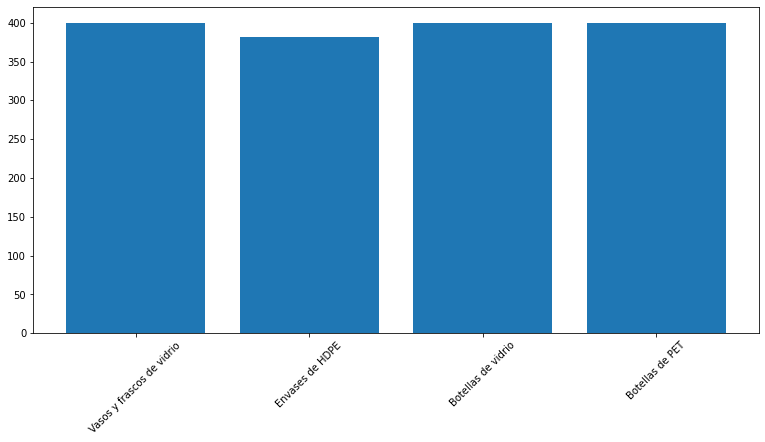

Clase Vasos y frascos de vidrio tiene 50 registros
Clase Envases de HDPE tiene 47 registros
Clase Botellas de vidrio tiene 50 registros
Clase Botellas de PET tiene 50 registros


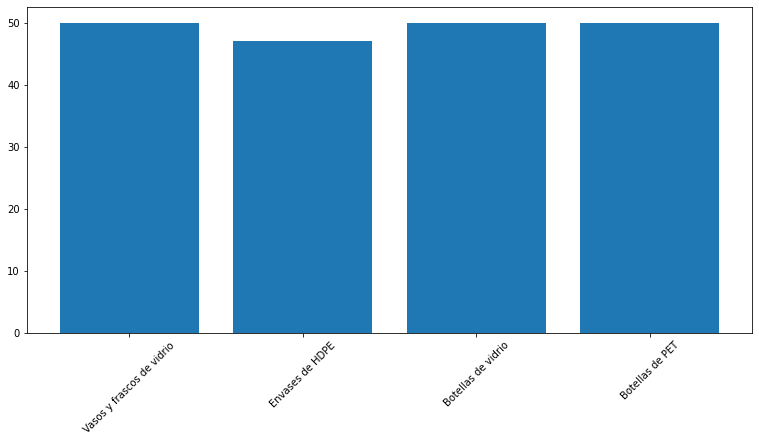

Clase Vasos y frascos de vidrio tiene 50 registros
Clase Envases de HDPE tiene 50 registros
Clase Botellas de vidrio tiene 50 registros
Clase Botellas de PET tiene 50 registros


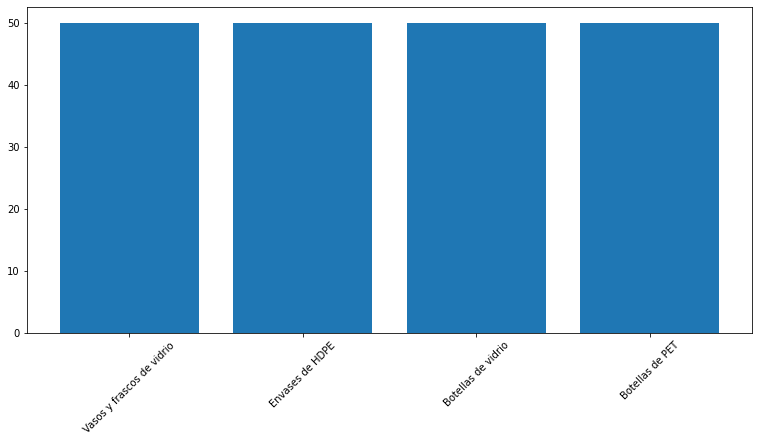

In [ ]:
DATA_PATH="/content/data"
Show_data(DATA_PATH, "train")
Show_data(DATA_PATH, "val")
Show_data(DATA_PATH, "test")

### **3.2. Clases para leer el dataset**

In [ ]:
class my_dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index): #indices de los batches
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]      

        #plt.imshow(x)    
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)

In [ ]:
class DataModule(pl.LightningDataModule):
    def __init__(self, dat_norm, data_dir:str, img_size = 224, batch_size = 200):
        super().__init__()

        self.data_dir = data_dir
        self.img_size = img_size

        self.transform = transforms.Compose([
            transforms.Resize(size = self.img_size),
            transforms.ToTensor(),
            transforms.Normalize(dat_norm[0], dat_norm[1])
        ])

        self.train_transform = transforms.Compose([
            transforms.Resize(size = self.img_size),
            transforms.RandomRotation(degrees=15),
            transforms.CenterCrop(size=self.img_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(dat_norm[0], dat_norm[1])
        ])

        self.batch_size = batch_size
        self.num_workers = 2
    
    def setup(self, stage = None):        
        path_train = os.path.join(self.data_dir, 'train')
        path_valid=  os.path.join(self.data_dir, 'val')
        path_test =  os.path.join(self.data_dir, 'test')

        data_train = datasets.ImageFolder(root = path_train)
        data_valid = datasets.ImageFolder(root = path_valid)
        data_test  = datasets.ImageFolder(root = path_test)

        self.traindata = my_dataset(data_train, self.train_transform)
        self.validdata = my_dataset(data_valid, self.train_transform)
        self.testdata  = my_dataset(data_test , self.transform)
        self.path_test = path_test
        self.categories  =  data_test.class_to_idx

    def train_dataloader(self):
        train_loader = torch.utils.data.DataLoader(
            self.traindata, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers, 
            shuffle = True,
            drop_last=True)
        return train_loader
    def val_dataloader(self):
        valid_loader = torch.utils.data.DataLoader(
            self.validdata, 
            batch_size=self.batch_size, 
            num_workers=self.num_workers, 
            drop_last=True)
        return valid_loader
    def test_dataloader(self):
        test_loader = torch.utils.data.DataLoader(
            self.testdata, 
            batch_size=self.batch_size,
            num_workers=self.num_workers, 
            drop_last=True)
        return test_loader

In [ ]:
def saveModel(model): 
    dir_Save ="/content/drive/MyDrive/Inteligencia Artificial/PROYECTO"
    path = os.path.join(dir_Save, "NetModel.pth")
    torch.save(model.state_dict(), path) 

* **Probando nuestras clases**

In [ ]:
dm = DataModule([(0.5,0.5,0.5),(0.5,0.5,0.5)], data_dir = DATA_PATH, img_size = 224, batch_size=10)
dm.setup()
class_names = dm.categories
class_names

{'Botellas de PET': 0,
 'Botellas de vidrio': 1,
 'Envases de HDPE': 2,
 'Vasos y frascos de vidrio': 3}

* **Observando algunas muestras**

201


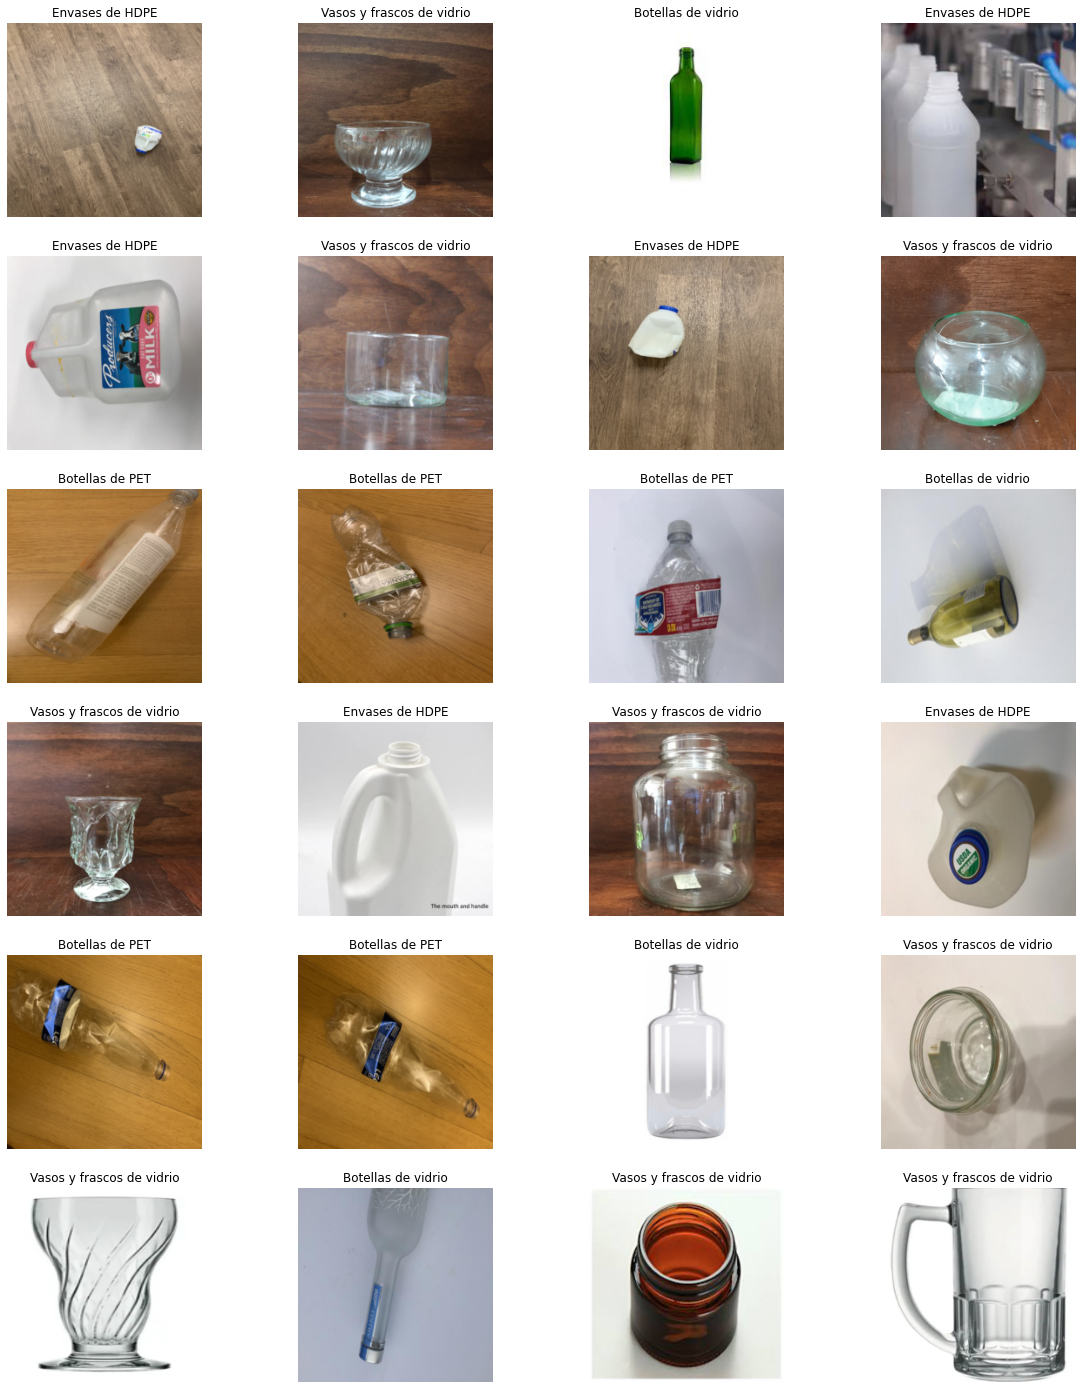

In [ ]:
path_test =  os.path.join(DATA_PATH, 'test')
MD=my_dataset(datasets.ImageFolder(root = path_test))
print(MD.__len__())
inv_map = {v: k for k, v in class_names.items()}
plt.figure(figsize=(20, 25))
for i in range(24):
  pos = np.random.randint(MD.__len__())
  ax = plt.subplot(6,4, i + 1)
  x, y = MD.__getitem__(pos)
  x = transforms.Resize(size = (224,224))(x)
  plt.imshow(x)
  plt.title(inv_map[y])
  plt.axis("off")
  

## **4. Configurando funciones de Train and Test**

In [ ]:
def train(model, criterion, device, train_loader, valid_loader, optimizer, num_epochs, porc=0):
    log_interval = 10
    print("Begin training...") 
    total = (len(train_loader) + len(valid_loader))*num_epochs
    
    n = len(list(model.parameters()))

    # Early stopping
    patience = 2
    triggertimes = 0
    current_val_loss = 100

    if porc>0:
      print(f"APLICANDO FINE TUNING. \n Descongelando el {porc*100}% de capas.")
      for i, param in enumerate(model.parameters()):
        if i>n*(1-porc):
          #print("entre a esta linea")
          param.requires_grad = True
    else:
      print(f"APLICANDO TRANSFER LEARNING. \n Entrenando Bloque añadido.")
    
    history = []
    best_accuracy = 0   

    for epoch in range(1, num_epochs+1): 
      model.train()
      running_train_loss = 0.0 
      
      total = 0 
      for batch_idx, (img, target) in enumerate(train_loader):
        img, target = img.to(device), target.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward and backward propagation
        output = model(img)
        train_loss = criterion(input=output, target=target)
        train_loss.backward()
        optimizer.step()

        # Show progress
        running_train_loss +=train_loss.item()
        if batch_idx % log_interval == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(img), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss.item()))

      train_loss_value = running_train_loss/len(train_loader)
      
      # Validation Loop 
      val_loss_value, accuracy = validation(model, valid_loader)
      history.append((train_loss_value, val_loss_value, accuracy))
      
      print('COMPLETED Train Epoch ', epoch, ': Training Loss is: %.4f ' %train_loss_value,' - Validation Loss is: %.4f' %val_loss_value, ' - Accuracy is %d %%' % (accuracy))
      
      if accuracy > best_accuracy: 
          print(f'Validation Accuracy increment ({best_accuracy:.6f}--->{accuracy:.6f}) \t Saving The Model')
          saveModel(model) 
          best_accuracy = accuracy 

    return model, history

In [ ]:
def validation(model, valid_loader):
  model.eval()
  running_vall_loss = 0.0
  with torch.no_grad():
    total = 0.0
    running_accuracy = 0.0
    for img, target in valid_loader: 
      img, target  = img.to(device), target.to(device)
      predicted_outputs = model(img)
      val_loss = criterion(predicted_outputs, target) 
      _, predicted = torch.max(predicted_outputs, 1) 
      running_vall_loss += val_loss.item()  
      total += target.size(0) 
      running_accuracy += (predicted == target).sum().item()
    print(running_accuracy)
    print(len(valid_loader))        
    val_loss_value = running_vall_loss/len(valid_loader)
    accuracy = (100 * running_accuracy / total)
  return val_loss_value, accuracy


In [ ]:
def test(model, criterion, device, test_loader):
    model.eval()
    test_loss = 0
    log_interval = 10
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    with torch.no_grad():
        for img, target in test_loader:
            img, target = img.to(device), target.to(device)
            output = model(img)
            test_loss += criterion(output, target).item()           
            all_preds = torch.cat(
            (all_preds, output)
            ,dim=0
            )
            all_labels = torch.cat(
                        (all_labels, target)
                        ,dim=0
            )

    test_loss /= len(test_loader.dataset)
    y_true = all_labels.cpu()
    y_pred = all_preds.argmax(dim=1).cpu()
    print(f'Test set: Average loss: \t{test_loss:.4f}')
    print(f'Test set: Accuracy score:\t{sk_metrics.accuracy_score(y_true, y_pred)}')
    print(f'Test set: Macro F1 score:\t{sk_metrics.f1_score(y_true, y_pred, average="macro")}')
    return y_pred, y_true

## **5. Elección del modelo**

In [ ]:
timm.list_models("resnet*", pretrained=True)

['resnet10t',
 'resnet14t',
 'resnet18',
 'resnet18d',
 'resnet26',
 'resnet26d',
 'resnet26t',
 'resnet32ts',
 'resnet33ts',
 'resnet34',
 'resnet34d',
 'resnet50',
 'resnet50_gn',
 'resnet50d',
 'resnet51q',
 'resnet61q',
 'resnet101',
 'resnet101d',
 'resnet152',
 'resnet152d',
 'resnet200d',
 'resnetaa50',
 'resnetblur50',
 'resnetrs50',
 'resnetrs101',
 'resnetrs152',
 'resnetrs200',
 'resnetrs270',
 'resnetrs350',
 'resnetrs420',
 'resnetv2_50',
 'resnetv2_50d_evos',
 'resnetv2_50d_gn',
 'resnetv2_50x1_bit_distilled',
 'resnetv2_50x1_bitm',
 'resnetv2_50x1_bitm_in21k',
 'resnetv2_50x3_bitm',
 'resnetv2_50x3_bitm_in21k',
 'resnetv2_101',
 'resnetv2_101x1_bitm',
 'resnetv2_101x1_bitm_in21k',
 'resnetv2_101x3_bitm',
 'resnetv2_101x3_bitm_in21k',
 'resnetv2_152x2_bit_teacher',
 'resnetv2_152x2_bit_teacher_384',
 'resnetv2_152x2_bitm',
 'resnetv2_152x2_bitm_in21k',
 'resnetv2_152x4_bitm',
 'resnetv2_152x4_bitm_in21k']

In [ ]:
modelo = timm.create_model("resnet34d", pretrained=True)
modelo.default_cfg

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34d_ra2-f8dcfcaf.pth" to /root/.cache/torch/hub/checkpoints/resnet34d_ra2-f8dcfcaf.pth


{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34d_ra2-f8dcfcaf.pth',
 'architecture': 'resnet34d',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.875,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv1.0',
 'classifier': 'fc'}

## **6. Modelo Resnet 34**

### **6.1. Creando la Arquitectura**

In [ ]:
class CNN_RESNET34(nn.Module):
    def __init__(self, num_classes = 4, pretrained = True):
        super().__init__()
        
        self.num_classes = num_classes

        # Para MOBILENET
        self.resnet34 = timm.create_model("resnet34d", pretrained = pretrained)
        if pretrained:
          # freeze  weights
            for param in self.resnet34.parameters():
              param.requires_grad = False 

        self.numfeat = self.resnet34.get_classifier().in_features
        
        block = nn.Sequential(
            nn.Linear(self.numfeat, 1024), 
            nn.Dropout(0.3),
            nn.Linear(1024, self.num_classes))                 

        self.resnet34.fc = block       

    def forward(self, x):
        out = self.resnet34.forward(x)
        return out

    def get_mean_std(self):
      return self.resnet34.default_cfg["mean"], self.resnet34.default_cfg["std"]

### **6.2. Configurando Hiperparámetros**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(47)

In [ ]:
num_class  = 4
lr         = 1e-4
num_epchs  = 10
batch_size = 5
img_size   = 224
base_dir   = "/content/data"
criterion  = nn.CrossEntropyLoss().to(device)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
model_resnet34 = CNN_RESNET34(num_classes=num_class).to(device)
optimizer =  torch.optim.Adam(model_resnet34.parameters(), lr=lr)
dm = DataModule(model_resnet34.get_mean_std(), data_dir = base_dir, img_size = img_size, batch_size=batch_size)
dm.setup()
train_loader = dm.train_dataloader()
valid_loader = dm.val_dataloader()

### **6.3. Entrenando el Modelo**

In [ ]:
model_resnet34, history = train(model_resnet34, criterion, device, train_loader, valid_loader, optimizer, num_epchs, porc = 0.20)

Begin training...
APLICANDO FINE TUNING. 
 Descongelando el 20.0% de capas.
Train Epoch: 1 [0/1599 (0%)]	Loss: 1.446668
Train Epoch: 1 [50/1599 (3%)]	Loss: 1.463308
Train Epoch: 1 [100/1599 (6%)]	Loss: 1.173404
Train Epoch: 1 [150/1599 (9%)]	Loss: 1.241545
Train Epoch: 1 [200/1599 (13%)]	Loss: 1.098880
Train Epoch: 1 [250/1599 (16%)]	Loss: 0.902022
Train Epoch: 1 [300/1599 (19%)]	Loss: 1.265457
Train Epoch: 1 [350/1599 (22%)]	Loss: 0.698951
Train Epoch: 1 [400/1599 (25%)]	Loss: 1.029663
Train Epoch: 1 [450/1599 (28%)]	Loss: 0.524362
Train Epoch: 1 [500/1599 (31%)]	Loss: 0.697861
Train Epoch: 1 [550/1599 (34%)]	Loss: 0.973085
Train Epoch: 1 [600/1599 (38%)]	Loss: 0.369061
Train Epoch: 1 [650/1599 (41%)]	Loss: 0.967895
Train Epoch: 1 [700/1599 (44%)]	Loss: 0.816859
Train Epoch: 1 [750/1599 (47%)]	Loss: 0.192208
Train Epoch: 1 [800/1599 (50%)]	Loss: 0.420543
Train Epoch: 1 [850/1599 (53%)]	Loss: 0.191890
Train Epoch: 1 [900/1599 (56%)]	Loss: 0.874942
Train Epoch: 1 [950/1599 (60%)]	Loss: 

* **Graficar Historial**

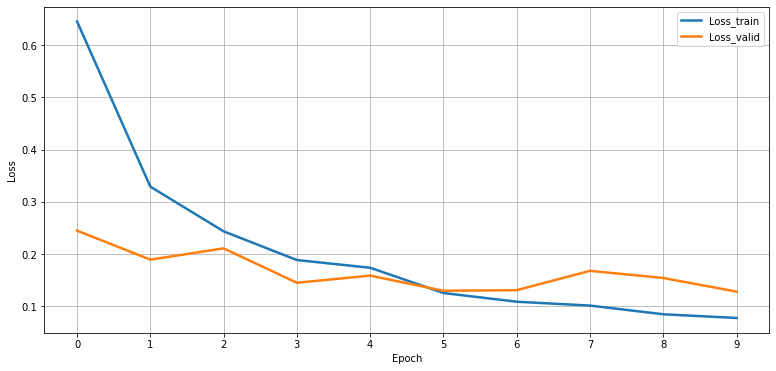

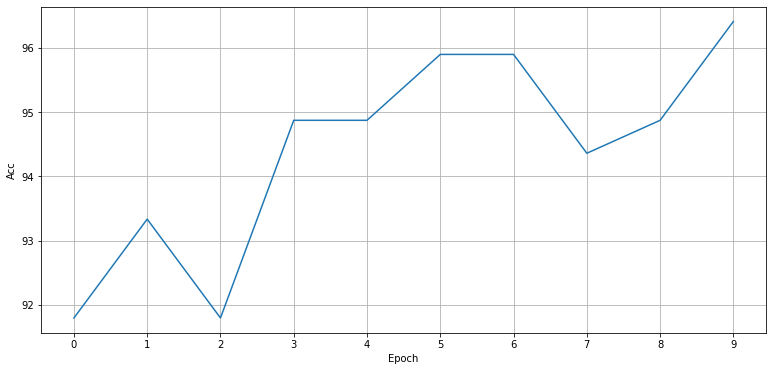

In [ ]:
arr = np.array(history)
plt.figure(figsize=(13,6))
plt.plot(arr[:,0], label="Loss_train", linewidth=2.5)
plt.plot(arr[:,1], label="Loss_valid", linewidth=2.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(np.arange(0, num_epchs))
plt.grid()
plt.show()
plt.figure(figsize=(13,6))
plt.plot(arr[:,2], label="Acc_valid")
plt.xlabel("Epoch")
plt.ylabel("Acc")
plt.xticks(np.arange(0, num_epchs))
plt.grid()
plt.show()

### **6.4. Pruebas**

In [ ]:
model_sv = CNN_RESNET34(num_classes=num_class).to(device)
path = "/content/drive/MyDrive/Inteligencia Artificial/PROYECTO/NetModel.pth"
model_sv.load_state_dict(torch.load(path)) 

<All keys matched successfully>

In [ ]:
dm = DataModule(model_sv.get_mean_std(), data_dir = base_dir, img_size = img_size, batch_size=1)
dm.setup()
loader = dm.test_dataloader()
labels = list(dm.categories)
y_pred, y_true = test(model_sv, criterion, device, loader)

Test set: Average loss: 	0.0932
Test set: Accuracy score:	0.9800995024875622
Test set: Macro F1 score:	0.979997057958223


In [ ]:
cm = confusion_matrix(y_true, y_pred)
tot = np.sum(cm, axis=1)
cm_porc = np.divide(cm, np.reshape(tot, (-1,1)))

* **Matriz de confusión en porcentajes**

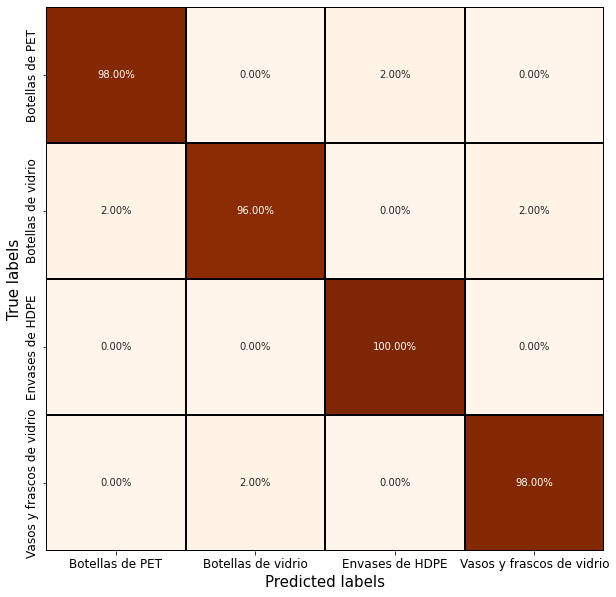

In [ ]:
labels = list(dm.categories)
# Calculate confusion matrix
df_confusion_matrix = pd.DataFrame(cm_porc, index=labels, columns=labels)

# Show confusion matrix
plt.figure(figsize=(10, 10))
sn.heatmap(df_confusion_matrix, annot=True, cbar=False, cmap='Oranges', linewidths=1, linecolor='black', fmt=".2%")
plt.xlabel('Predicted labels', fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('True labels', fontsize=15)
plt.yticks(fontsize=12);

* **Matriz de confusión con cantidades**

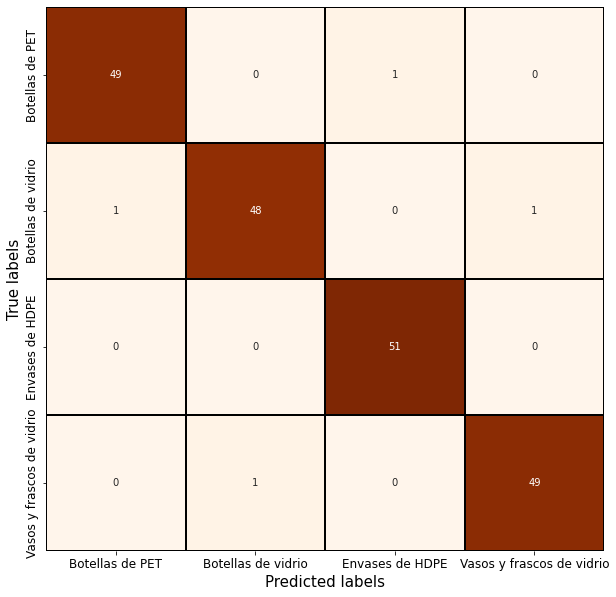

In [ ]:
labels = list(dm.categories)
# Calculate confusion matrix
df_confusion_matrix = pd.DataFrame(cm, index=labels, columns=labels)

# Show confusion matrix
plt.figure(figsize=(10, 10))
sn.heatmap(df_confusion_matrix, annot=True, cbar=False, cmap='Oranges', linewidths=1, linecolor='black')
plt.xlabel('Predicted labels', fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('True labels', fontsize=15)
plt.yticks(fontsize=12);

In [ ]:
report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
print(classification_report(y_true, y_pred, target_names=labels))

                           precision    recall  f1-score   support

          Botellas de PET       0.98      0.98      0.98        50
       Botellas de vidrio       0.98      0.96      0.97        50
          Envases de HDPE       0.98      1.00      0.99        51
Vasos y frascos de vidrio       0.98      0.98      0.98        50

                 accuracy                           0.98       201
                macro avg       0.98      0.98      0.98       201
             weighted avg       0.98      0.98      0.98       201

